Found 18 clusters.


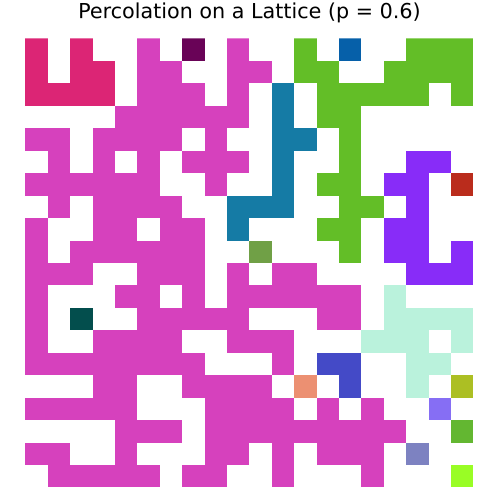

In [12]:
using Random, Colors, Plots

# Generate an L×L lattice where each site is occupied with probability p.
function generate_lattice(L::Int, p::Float64)
    return rand(L, L) .< p
end

# Depth-first search to label connected clusters.
function label_cluster!(labels::Matrix{Int}, lat::BitMatrix, i::Int, j::Int, label::Int)
    L = size(lat, 1)
    # Boundary and condition check.
    if i < 1 || i > L || j < 1 || j > L || !lat[i, j] || labels[i, j] != 0
        return
    end
    labels[i, j] = label
    # Explore neighbors (4-neighbor connectivity).
    label_cluster!(labels, lat, i+1, j, label)
    label_cluster!(labels, lat, i-1, j, label)
    label_cluster!(labels, lat, i, j+1, label)
    label_cluster!(labels, lat, i, j-1, label)
end

# Identify clusters in the lattice.
function find_clusters(lat::BitMatrix)
    L = size(lat, 1)
    labels = zeros(Int, L, L)
    current_label = 0
    for i in 1:L, j in 1:L
        if lat[i, j] && labels[i, j] == 0
            current_label += 1
            label_cluster!(labels, lat, i, j, current_label)
        end
    end
    return labels, current_label
end

# Parameters
L = 20
p = 0.6  # near the percolation threshold

# Generate lattice and label clusters.
lat = generate_lattice(L, p)
labels, nclusters = find_clusters(lat)
println("Found $nclusters clusters.")

# Create a color mapping: label 0 (empty) will be white.
colors_map = Dict{Int, Colorant}()
colors_map[0] = RGB(1,1,1)
for label in 1:nclusters
    colors_map[label] = RGB(rand(), rand(), rand())
end

# Build a matrix of colors based on cluster labels.
color_matrix = [colors_map[labels[i, j]] for i in 1:L, j in 1:L]

# Plot the percolation results.
heatmap(color_matrix,
        aspect_ratio=1,
        axis=nothing,
        border=:none,
        title="Percolation on a Lattice (p = $p)",
        size=(500,500))

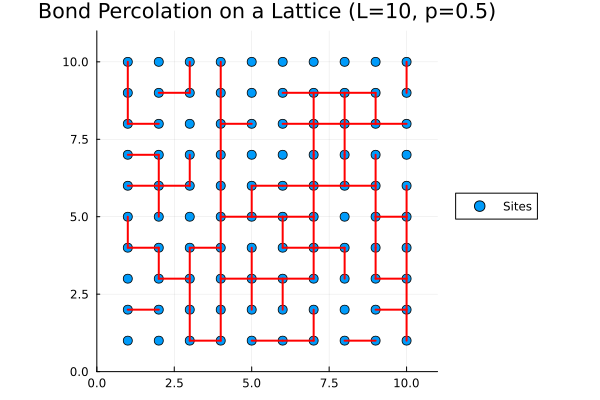

In [10]:
using Random, Plots

# Function to visualize bond percolation on a square lattice.
function visualize_bond_percolation(L::Int, p::Float64)
    # LxL lattice: sites located at integer coordinates (1,1) to (L,L)
    # Bonds: horizontal bonds between (i, j) and (i+1, j) for i = 1:(L-1), j = 1:L
    #        vertical bonds between (i, j) and (i, j+1) for i = 1:L, j = 1:(L-1)
    h_bonds = []  # list for horizontal bonds
    v_bonds = []  # list for vertical bonds

    # Determine horizontal bonds.
    for j in 1:L
        for i in 1:(L-1)
            if rand() < p
                push!(h_bonds, ((i, j), (i+1, j)))
            end
        end
    end

    # Determine vertical bonds.
    for i in 1:L
        for j in 1:(L-1)
            if rand() < p
                push!(v_bonds, ((i, j), (i, j+1)))
            end
        end
    end

    # Plot lattice sites as points.
    xs = [i for i in 1:L, j in 1:L] |> vec
    ys = [j for i in 1:L, j in 1:L] |> vec
    scatter(xs, ys, markersize=5, label="Sites", aspect_ratio=1,
            xlims=(0, L+1), ylims=(0, L+1), legend=:bottomright)

    # Draw horizontal bonds in blue.
    for bond in h_bonds
        p1, p2 = bond
        plot!([p1[1], p2[1]], [p1[2], p2[2]], lw=2, color=:red, label=false)
    end

    # Draw vertical bonds in red.
    for bond in v_bonds
        p1, p2 = bond
        plot!([p1[1], p2[1]], [p1[2], p2[2]], lw=2, color=:red, label=false,legend=:outerright)
    end

    title!("Bond Percolation on a Lattice (L=$L, p=$p)")
end

# Example usage: 10x10 lattice with bond probability 0.5
visualize_bond_percolation(10, 0.5)

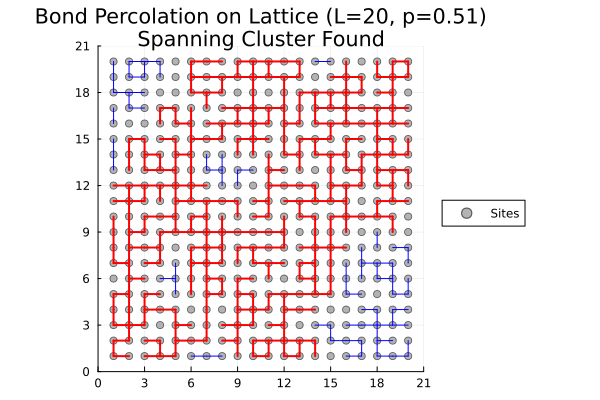

In [7]:
using Random, Plots

# ------------------------------
# Union-Find Data Structure
# ------------------------------
mutable struct UnionFind
    parent::Vector{Int}
end

function UnionFind(n::Int)
    return UnionFind(collect(1:n))
end

function uf_find(uf::UnionFind, x::Int)
    while uf.parent[x] != x
        uf.parent[x] = uf.parent[uf.parent[x]]  # Path halving.
        x = uf.parent[x]
    end
    return x
end

function uf_union!(uf::UnionFind, x::Int, y::Int)
    root_x = uf_find(uf, x)
    root_y = uf_find(uf, y)
    if root_x != root_y
        uf.parent[root_y] = root_x
    end
end

# ------------------------------
# Helper function: Map (i,j) to node index.
# ------------------------------
# For an L×L lattice, use 1-based indexing:
#   node index = (i - 1)*L + j
function node_index(i::Int, j::Int, L::Int)
    return (i - 1) * L + j
end

# ------------------------------
# Visualize Bond Percolation and Identify Spanning Cluster
# ------------------------------
function visualize_bond_percolation_with_cluster(L::Int, p::Float64)
    # Create lists for open bonds.
    h_bonds = []  # horizontal bonds: between (i,j) and (i+1,j)
    v_bonds = []  # vertical bonds: between (i,j) and (i,j+1)

    # Generate horizontal bonds.
    for j in 1:L
        for i in 1:(L - 1)
            if rand() < p
                push!(h_bonds, ((i, j), (i + 1, j)))
            end
        end
    end

    # Generate vertical bonds.
    for i in 1:L
        for j in 1:(L - 1)
            if rand() < p
                push!(v_bonds, ((i, j), (i, j + 1)))
            end
        end
    end

    # Initialize Union-Find structure.
    N = L * L
    uf = UnionFind(N)

    # Process horizontal bonds.
    for bond in h_bonds
        (p1, p2) = bond
        idx1 = node_index(p1[1], p1[2], L)
        idx2 = node_index(p2[1], p2[2], L)
        uf_union!(uf, idx1, idx2)
    end

    # Process vertical bonds.
    for bond in v_bonds
        (p1, p2) = bond
        idx1 = node_index(p1[1], p1[2], L)
        idx2 = node_index(p2[1], p2[2], L)
        uf_union!(uf, idx1, idx2)
    end

    # Identify a spanning (percolating) cluster:
    # Here, we define percolation as a cluster connecting the top row to the bottom row.
    top_nodes = [node_index(1, j, L) for j in 1:L]
    bottom_nodes = [node_index(L, j, L) for j in 1:L]

    top_roots = Set(uf_find(uf, node) for node in top_nodes)
    bottom_roots = Set(uf_find(uf, node) for node in bottom_nodes)
    spanning_clusters = intersect(top_roots, bottom_roots)
    spanning_cluster = isempty(spanning_clusters) ? nothing : first(spanning_clusters)

    # Prepare to plot:
    xs = [i for i in 1:L, j in 1:L] |> vec
    ys = [j for i in 1:L, j in 1:L] |> vec

    scatter(xs, ys, markersize=4, label="Sites", aspect_ratio=1,
            xlims=(0, L + 1), ylims=(0, L + 1),alpha=0.6,color=:grey)

    # Draw bonds, highlighting those that are part of the spanning cluster.
    for bond in h_bonds
        p1, p2 = bond
        idx1 = node_index(p1[1], p1[2], L)
        idx2 = node_index(p2[1], p2[2], L)
        r1 = uf_find(uf, idx1)
        r2 = uf_find(uf, idx2)
        if spanning_cluster !== nothing && r1 == spanning_cluster && r2 == spanning_cluster
            plot!([p1[1], p2[1]], [p1[2], p2[2]], lw=2, color=:red, label="")
        else
            plot!([p1[1], p2[1]], [p1[2], p2[2]], lw=1, color=:blue, label="")
        end
    end

    for bond in v_bonds
        p1, p2 = bond
        idx1 = node_index(p1[1], p1[2], L)
        idx2 = node_index(p2[1], p2[2], L)
        r1 = uf_find(uf, idx1)
        r2 = uf_find(uf, idx2)
        if spanning_cluster !== nothing && r1 == spanning_cluster && r2 == spanning_cluster
            plot!([p1[1], p2[1]], [p1[2], p2[2]], lw=2, color=:red, label="")
        else
            plot!([p1[1], p2[1]], [p1[2], p2[2]], lw=1, color=:blue, label="",legend=:outerright)
        end
    end

    if spanning_cluster !== nothing
        title!("Bond Percolation on Lattice (L=$L, p=$p)\nSpanning Cluster Found", font=:bold)
    else
        title!("Bond Percolation on Lattice (L=$L, p=$p)\nNo Spanning Cluster", font=:bold)
    end
end

# Example usage:
visualize_bond_percolation_with_cluster(20, 0.51)